In [51]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow.keras import layers

from tqdm import tqdm

#load cifar100, display a random image
#(train_data, val_data, test_data), metadata = tfds.load(
#    'cifar10',
#    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
#    with_info=True,
#    #as_supervised=True,
#)
#num_classes = metadata.features['label'].num_classes
#print(num_classes)

#get_label_name = metadata.features['label'].int2str



# Load CIFAR-10 dataset
(train_data, val_data, test_data), info = tfds.load('cifar10', split=['train[:80%]', 'train[80%:]', 'test'], 
                                             with_info=True, as_supervised=True)

# Define preprocessing function
IMG_SIZE = 32

def preprocess_image(image, label):
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Apply preprocessing function to datasets
train_data = train_data.map(preprocess_image)
val_data = val_data.map(preprocess_image)
test_data = test_data.map(preprocess_image)

# Shuffle and batch datasets
BATCH_SIZE = 32

train_data = train_data.shuffle(buffer_size=10000)
train_data = train_data.batch(BATCH_SIZE)

val_data = val_data.batch(BATCH_SIZE)

test_data = test_data.batch(BATCH_SIZE,drop_remainder=True)



In [52]:
import os

#train_data=train_data.batch(32)
#val_data=val_data.batch(32)
#test_data=test_data.batch(32,drop_remainder=True)

#resize and rescale images - redefine since we are using batches of images now
IMG_SIZE = 32

data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.1),
        tf.keras.layers.RandomZoom(0.1),
    ]
)
def build_model(dropout_rate=0.2):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(32, 32, 3)),
        data_augmentation,
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    # Train the model
    history = model.fit(train_data, epochs=10, validation_data=val_data, batch_size=32)

    # Save the model
    model.save('models/CNNCIFAR10.h5')
    return model

if not os.path.exists('models/CNNCIFAR10.h5'):
    model=build_model()
else:
    model=tf.keras.models.load_model('models/CNNCIFAR10.h5')

In [53]:
test_loss, test_acc = model.evaluate(test_data) #since we specified metrics=[accuracy], evaluate() returns test_acc too.
                                                #dont pass labels since test_data contains them as it is a dataset
print('Test loss:', test_loss)
print('Test accuracy:', test_acc) 

312/312 [==============================] - 4s 11ms/step - loss: 0.9553 - accuracy: 0.6730
Test loss: 0.9553128480911255
Test accuracy: 0.6729767918586731


tf.Tensor([[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 10), dtype=float32)
24


100%|██████████| 10/10 [21:55<00:00, 131.50s/it]


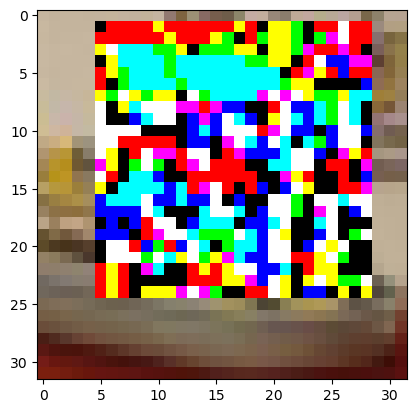

1/1 [==============================] - 0s 106ms/step
Original prediction: 3
1/1 [==============================] - 0s 24ms/step
Prediction with patch: 1
Probability of patch working: 0.8914563301282051
tf.Tensor(
[[[0. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 1.]
  [0. 1. 1.]
  ...
  [1. 0. 1.]
  [1. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [1. 1. 1.]]

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 0.]
  [0. 0. 0.]
  [1. 1. 0.]]], shape=(24, 24, 3), dtype=float32)
[[[0. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 1.]
  [0. 1. 1.]
  ...
  [1. 0. 1.]


In [54]:
import numpy as np
import random
import math
#test_data=test_data.shuffle(1000).take(1)
#for i, (image, labels) in enumerate(test_data):
#  img=image[0, ...]
#  label=labels[0]
#print(label)
#for images in test_data:

#patch_exists = tf.io.gfile.exists("patches/patch_20x20_cifar10")
if not os.path.exists('patches/patch_24x24_cifar10.npy'):
    #do below
    # Define the target class (toaster)
    #target_class = 1 95 in cifar100
    #indices=[0,0,0,0,0,0,0,0,0,0]
    indices=[9] #target_class=10
    target_class=tf.one_hot(indices,depth=10)
    print(target_class)
    #TODO: patch with random size (% of image) - max % of image will be 50% as shown in study
    patch_size=0.5 #end up with patch_size=height(=width)(=diameter)
    total_img=IMG_SIZE*IMG_SIZE*patch_size
    patch_size=round(math.sqrt(total_img))
    if (patch_size%2!=0):
        patch_size=patch_size+1
    half_size=patch_size/2 #distance from edge to centre of patch(=radius)
    half_size=int(half_size)
    #TODO: circular patch (and applying random rotations)
    # Generate the adversarial patch
    #patch_size = 20
    print(patch_size)

    #print(indices)
    #patch_value = tf.Variable(initial_value=tf.ones((patch_size, patch_size, 3)),dtype=tf.float32)
    patch_value = np.ones((patch_size, patch_size, 3))
    #patch_value = tf.ones((patch_size, patch_size, 3))
    #indices = tf.constant([[i, j] for i in range(patch_value[0], patch_value[0]+patch_size) for j in range(patch_value[1], patch_value[1]+patch_size)])
    learning_rate = 10
    num_iterations = 10
    patch_value=tf.convert_to_tensor(patch_value, dtype=tf.float32)
    #ran_x=random.randint(11,20)
    #ran_y=random.randint(11,20)
    def apply_patch2(original_image,patch,x,y):
        #TODO:insert patch with center x,y to image
        ##identity:tensor 32x32=1 so img*i=img
        #ident=tf.ones(IMG_SIZE,IMG_SIZE,3)
        #first set all pixels in the image where the patch would go to 0 - mask
        mask=
        #then expand the dimensions of the patch s.t. it is the same shape as the image but with 0's everywhere else other than the patch
        #then add them

    def apply_patch(original_image,patch,x,y):
        #apply patch to img with center x,y
        #find out how many rows are above the patch and columns to the left of the patch:
        #center can only be between 12,12 and 21,21
        #get rows above patch
        #get rows inline with patch
        #get rows below patch
        #concatenate all downwards
        #print(x,y)
        above=tf.concat([original_image[:x-half_size,:y-half_size,:],original_image[x-half_size:,:y-half_size,:]],axis=0)
        inl=tf.concat([original_image[:x-half_size,y-half_size:y+half_size,:],patch,original_image[x+half_size:,y-half_size:y+half_size,:]],axis=0)
        below=tf.concat([original_image[:x-half_size,y+half_size:,:],original_image[x-half_size:,y+half_size:,:]],axis=0)
        #print(below)
        patched_image=tf.concat([above,inl,below],axis=1)

        return patched_image
    def loss_func(pred):
        loss_per_example = tf.keras.losses.categorical_crossentropy(y_true=target_class, y_pred=pred, from_logits=False, label_smoothing=0)
        loss = tf.reduce_mean(loss_per_example)
        return loss

    #TODO: use trange for progress bar
    counter=0
    patch_misclassified=0
    for i in tqdm(range(num_iterations)):
        for batch in test_data:
            images,labels=batch
            for j in range(images.shape[0]):
                counter=counter+1
                img=images[j,...]
                label=labels[j]
                #plt.imshow(img)
                #plt.show()
                #TODO: allow partially visible patch? i.e only half the patch is shown, so only train the portion shown
                ran_x=random.randint(half_size+1,32-half_size-1)
                ran_y=random.randint(half_size+1,32-half_size-1)
                #place patch in random place
                
                #get the predictions for that image
                #get loss for that image
                #update patch
                #next image -> put patch in another random spot
                with tf.GradientTape() as tape:
                    tape.watch(patch_value)
                    #print(img)
                    img_patch = np.copy(img)
                    #patch_value = patch_value.numpy()
                    img_patch = tf.convert_to_tensor(img_patch, dtype=tf.float32)
                    img_patch=apply_patch(img_patch,patch_value,ran_x,ran_y)
                    predictions = model(img_patch[np.newaxis, ...])
                    #loss = -predictions[0][target_class]
                    #print('original:',tf.get_static_value(label))
                    #print('Prediction with patch:', np.argmax(predictions))
                    if (tf.get_static_value(label)!=np.argmax(predictions)):
                        patch_misclassified=patch_misclassified+1
                    loss = loss_func(predictions)
                gradients = tape.gradient(loss, patch_value)
                #patch_value = patch_value - learning_rate * gradients
                #tf.keras.optimizers.Adam().apply_gradients([(gradients,patch_value)])

                #projected gradient descent
                gradients = tf.sign(gradients) * learning_rate
                patch_value = patch_value + tf.squeeze(gradients)
                patch_value = tf.clip_by_value(patch_value, 0, 1)


    # Apply the adversarial patch to the image
    img_patch = np.copy(img)
    img_patch = tf.convert_to_tensor(img_patch, dtype=tf.float32)
    patched_image=apply_patch(img_patch,patch_value,ran_x,ran_y)

    plt.imshow(patched_image.numpy())
    plt.show()

    # Check the model's prediction on the original image
    prediction_orig = model.predict(img[np.newaxis, ...])
    print('Original prediction:', np.argmax(prediction_orig))

    # Check the model's prediction on the image with the adversarial patch
    prediction_patch = model.predict(patched_image[np.newaxis, ...])
    print('Prediction with patch:', np.argmax(prediction_patch))

    print('Probability of patch working:',patch_misclassified/counter)
    #TODO: run on computer using gpu
    #tf.io.write_file("patches/patch_20x20_cifar10",patch_value)
    #print(patch_value)
    #print(patch_value.numpy())
    np.save('patches/patch_24x24_cifar10.npy',patch_value.numpy()) 


In [55]:
patch_value=np.load("patches/patch_24x24_cifar10.npy")
patch_value=tf.convert_to_tensor(patch_value, dtype=tf.float32)
print(patch_value)

tf.Tensor(
[[[0. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 0. 0.]
  [1. 0. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 1.]
  [1. 0. 0.]
  [1. 0. 0.]]

 [[1. 1. 0.]
  [1. 1. 1.]
  [0. 1. 1.]
  ...
  [1. 0. 1.]
  [1. 0. 0.]
  [0. 0. 0.]]

 ...

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [0. 0. 0.]
  [0. 0. 0.]
  [0. 0. 0.]]

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [0. 1. 0.]
  [0. 1. 0.]
  [1. 1. 1.]]

 [[1. 0. 0.]
  [1. 1. 0.]
  [1. 0. 0.]
  ...
  [1. 1. 0.]
  [0. 0. 0.]
  [1. 1. 0.]]], shape=(24, 24, 3), dtype=float32)
